In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler


#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [4]:
df_train.shape

(58645, 13)

In [5]:
df_test.shape

(39098, 12)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [8]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [9]:
df_test.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [10]:
print(df_train.isnull().sum())

print(df_test.isnull().sum())

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [11]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [12]:
print(df_train.columns)
print(df_test.columns)


Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')
Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')


In [13]:
X_test = df_test.drop(['id'], axis = 1)

# **Exploratory Data Analysis**

In [14]:
X_test.value_counts(['person_home_ownership'])

person_home_ownership
RENT                     20280
MORTGAGE                 16683
OWN                       2056
OTHER                       79
Name: count, dtype: int64

person_home_ownership
RENT                     30594
MORTGAGE                 24824
OWN                       3138
OTHER                       89
Name: count, dtype: int64


<Axes: ylabel='person_home_ownership'>

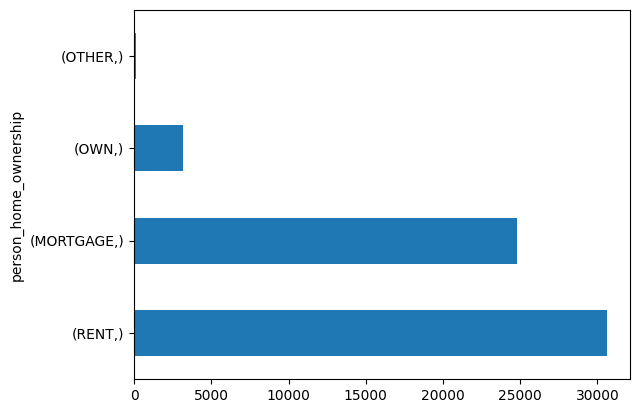

In [15]:
print(df_train.value_counts(['person_home_ownership']))
df_train.value_counts(['person_home_ownership']).plot(kind = 'barh')

loan_intent      
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64


<Axes: ylabel='count'>

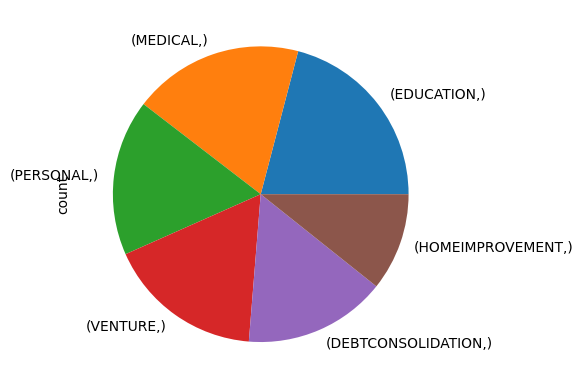

In [16]:
print (df_train.value_counts(['loan_intent']))
df_train.value_counts(['loan_intent']).plot(kind = 'pie')

loan_grade
A             20984
B             20400
C             11036
D              5034
E              1009
F               149
G                33
Name: count, dtype: int64


<Axes: xlabel='loan_grade'>

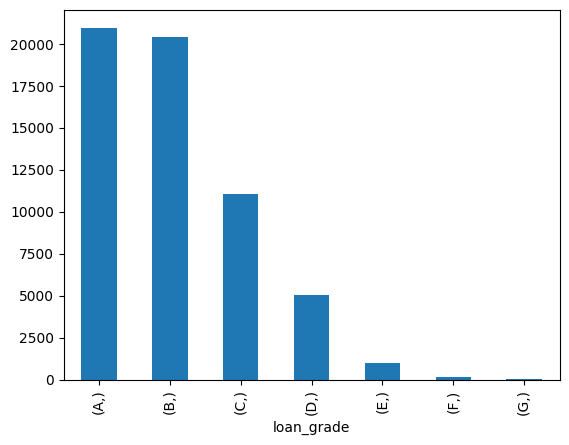

In [17]:
print(df_train.value_counts(['loan_grade']))
df_train.value_counts(['loan_grade']).plot(kind='bar')

loan_grade
A             14005
B             13604
C              7460
D              3269
E               637
F               105
G                18
Name: count, dtype: int64


<Axes: xlabel='loan_grade'>

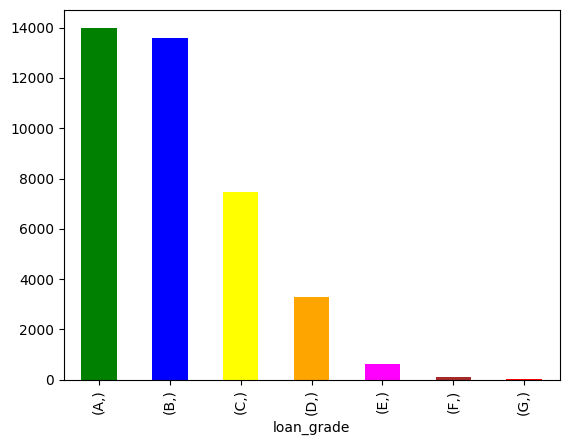

In [18]:
print(X_test.value_counts(['loan_grade']))
X_test.value_counts(['loan_grade']).plot(kind='bar', color = ['Green', 'Blue','Yellow','Orange', 'Magenta', 'Brown', 'Red'])

cb_person_default_on_file
N                            49943
Y                             8702
Name: count, dtype: int64


<Axes: ylabel='count'>

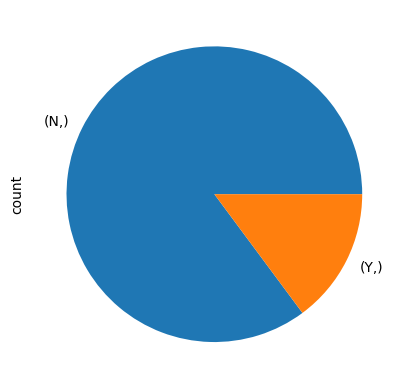

In [19]:
print(df_train.value_counts(['cb_person_default_on_file']))
df_train.value_counts(['cb_person_default_on_file']).plot(kind ='pie')

cb_person_default_on_file
N                            33227
Y                             5871
Name: count, dtype: int64


<Axes: xlabel='loan_status'>

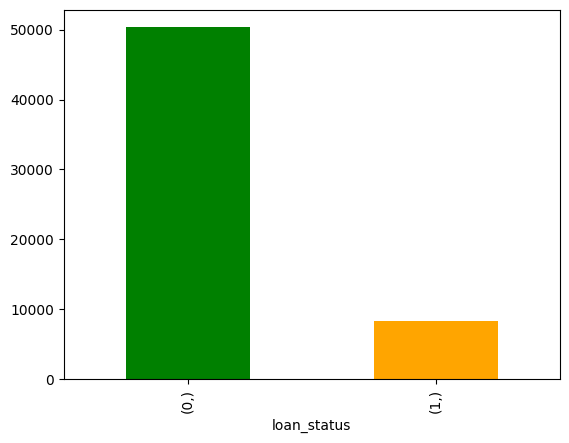

In [20]:
print(X_test.value_counts(['cb_person_default_on_file']))
df_train.value_counts(['loan_status']).plot(kind = 'bar', color = ['Green', 'Orange'])

In [21]:
print('The percentage of people whose loan status would be accepted', df_train['loan_status'].value_counts()[1]/df_train['loan_status'].value_counts().sum() *100)

The percentage of people whose loan status would be accepted 14.238212976383323


> -There is high probability that our dataset would be highly skewed since around 14% of the people would have their loan accepted
Therefore, there is need to perform necessary data transformation to improve the sample of the minority class

> -From the data analysis that was conducted on the loan status variable, it is evident that the dataset was highly skewed therefore, to improve the performance of our analysis, we are going to perform data transformation to improve the sample minority class

# Checking for the Outliers

Axes(0.125,0.11;0.775x0.77)


person_income
False    56234
True      2411
Name: count, dtype: int64

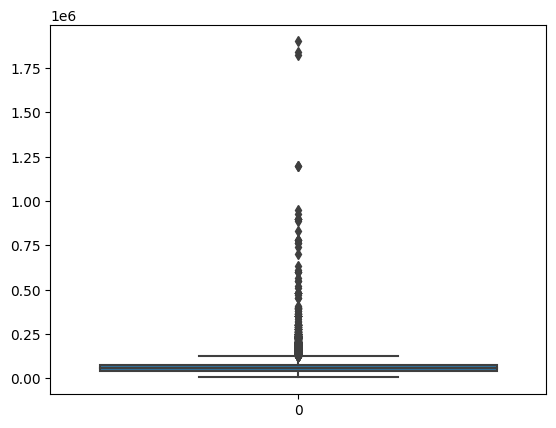

In [22]:
print(sns.boxplot(data = df_train['person_income']))

Q1_pi = df_train['person_income'].quantile(0.25)
Q3_pi = df_train['person_income'].quantile(0.75)

IQR_pi = Q3_pi - Q1_pi

O_pi = (df_train['person_income'] < (Q1_pi - 1.5 * IQR_pi)) | (df_train['person_income'] > (Q3_pi + 1.5 * IQR_pi))

O_pi.value_counts()

In [23]:
df_train_mean = df_train['person_income'].mean()
df_train_std = df_train['person_income'].std()

lowest = df_train_mean - (3 * df_train_std)
highest = df_train_mean + (3 * df_train_std)

pi_outlier = df_train[(df_train['person_income'] < lowest) | (df_train['person_income'] > highest)]

pi_outlier.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
91,91,24,225000,RENT,0.0,MEDICAL,C,3000,14.26,0.01,Y,2,0
144,144,27,200000,MORTGAGE,7.0,EDUCATION,A,24000,7.49,0.12,N,7,0
470,470,28,192000,MORTGAGE,13.0,HOMEIMPROVEMENT,C,20000,13.48,0.11,Y,8,0
489,489,24,200100,MORTGAGE,8.0,DEBTCONSOLIDATION,A,30000,7.90,0.15,N,4,0
583,583,22,250000,MORTGAGE,4.0,EDUCATION,A,10000,7.51,0.04,N,3,0


Axes(0.125,0.11;0.775x0.77)


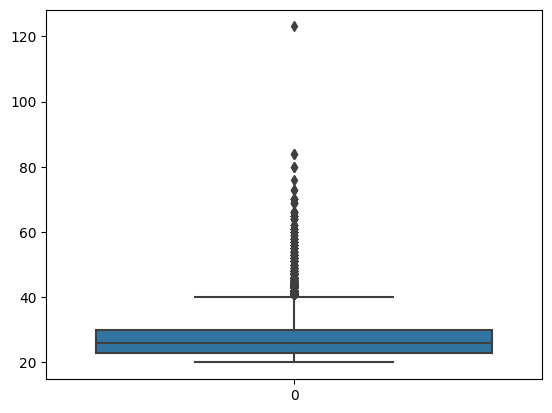

In [24]:
print(sns.boxplot(data = df_train['person_age']))

Axes(0.125,0.11;0.775x0.77)


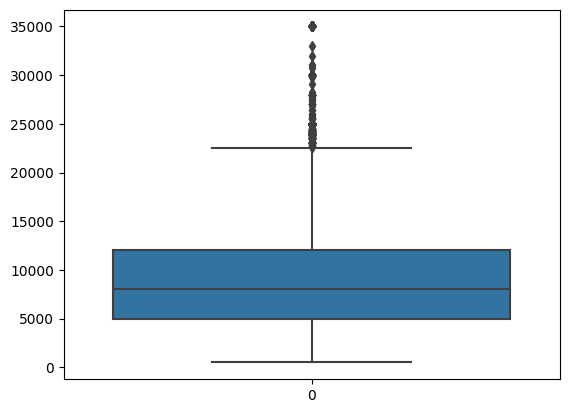

In [25]:
print(sns.boxplot(data = df_train['loan_amnt']))

<Axes: >

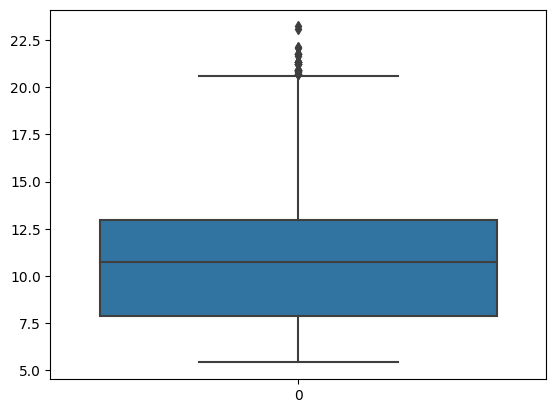

In [26]:
sns.boxplot(data = df_train['loan_int_rate'])

<Axes: >

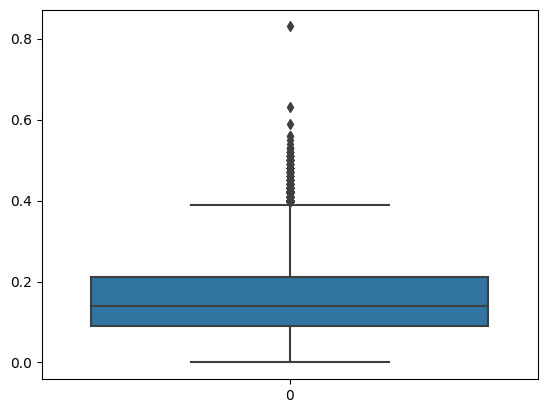

In [27]:
sns.boxplot(data = df_train['loan_percent_income'])

<Axes: >

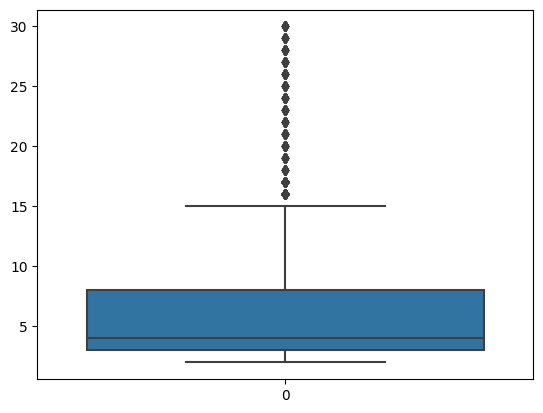

In [28]:
sns.boxplot(data = df_train['cb_person_cred_hist_length'])

<Axes: >

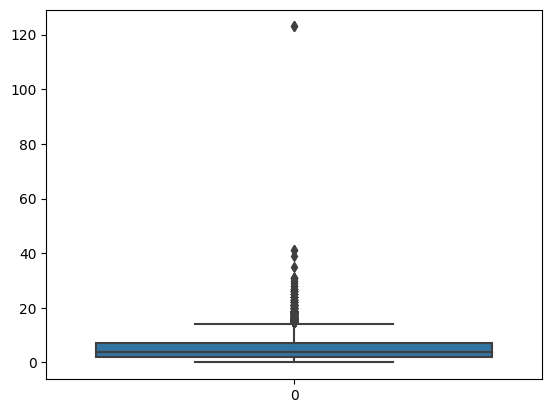

In [29]:
sns.boxplot(data = df_train['person_emp_length'])

# ****Splitting the dataset into Features and target variables****

In [30]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_train.drop(['id'], axis=1)

X_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


In [31]:
y_train.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

# Converting Categorical Values to Numerical Values

In [32]:
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Define ColumnTransformer for one-hot encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

In [33]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# ****Checking for Correlation from both train and test datasets****

<Axes: >

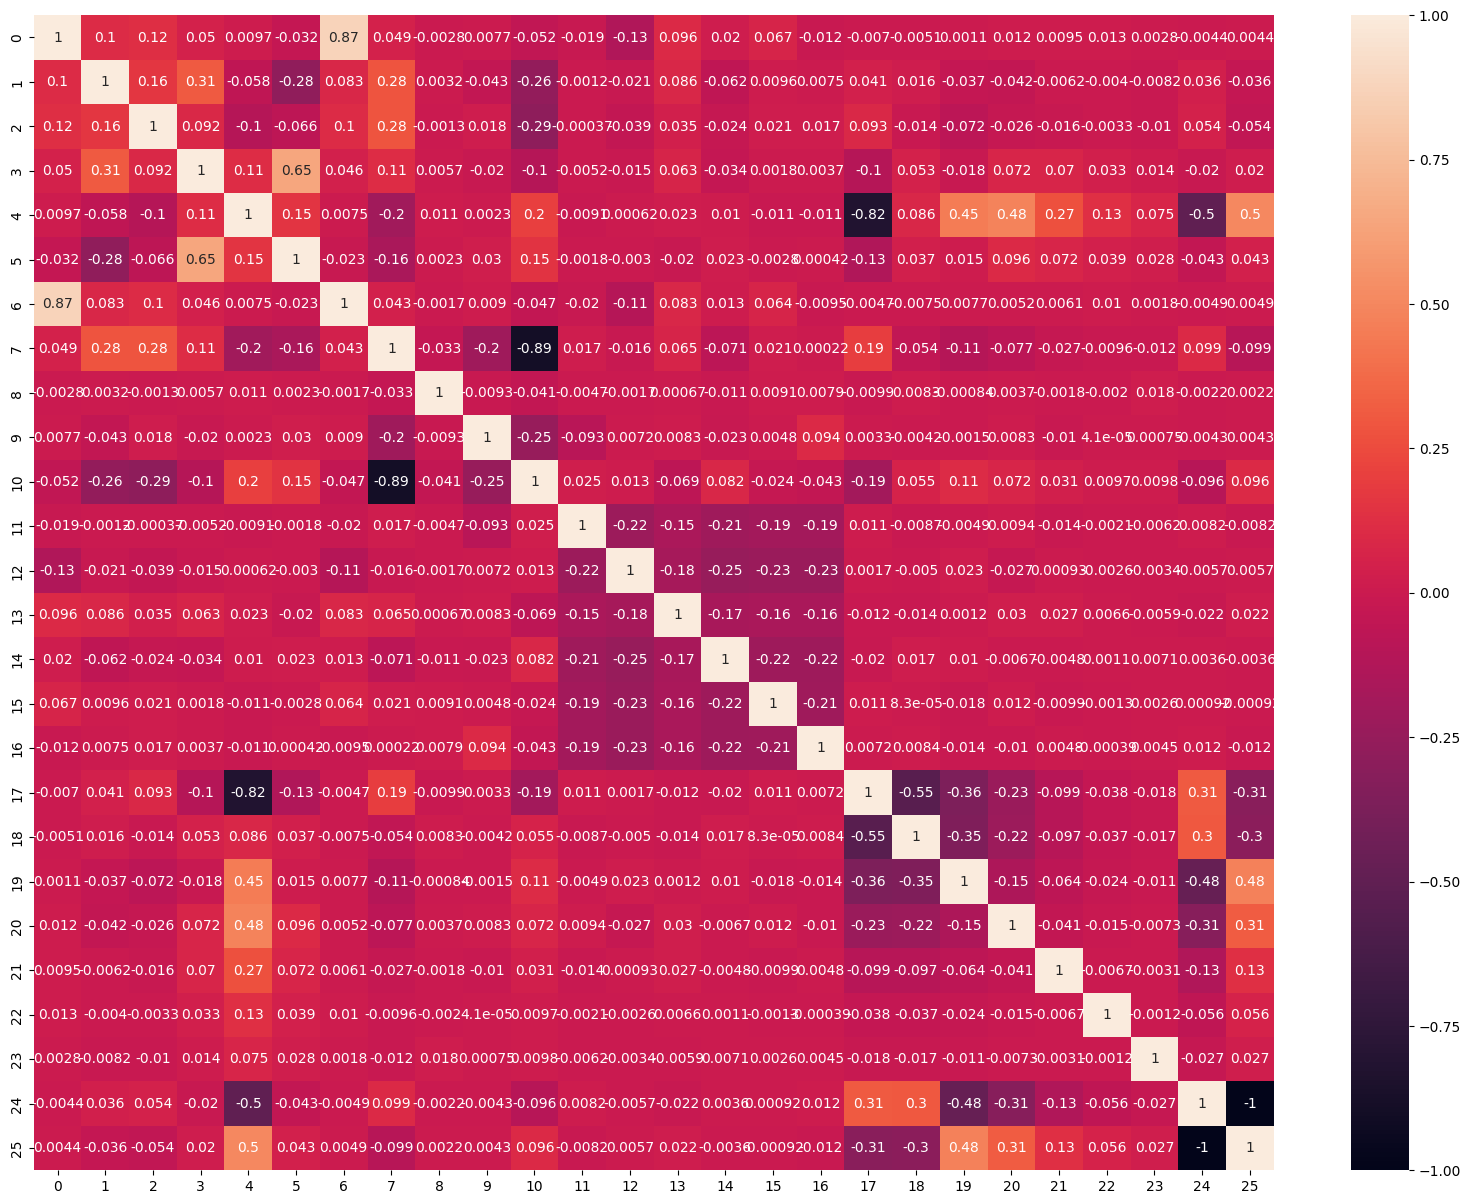

In [34]:
cor = X_train.corr()
f, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(cor, annot = True)

<Axes: >

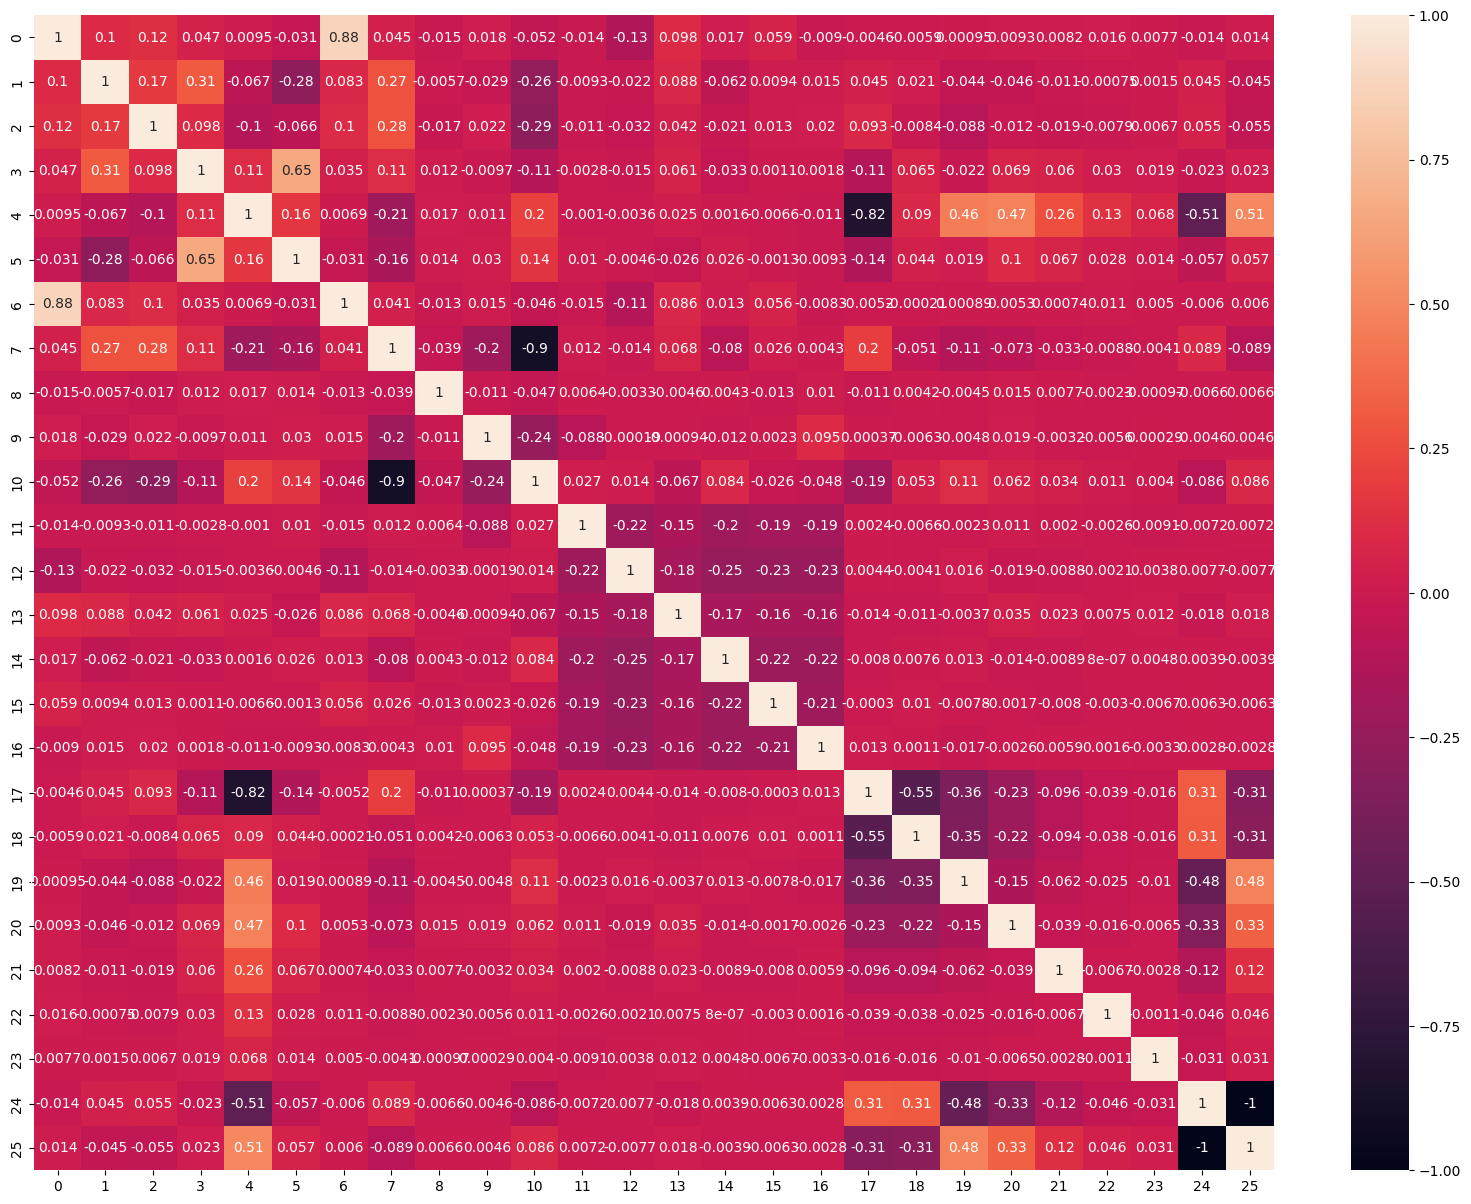

In [35]:
cor = X_test.corr()
f, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(cor, annot = True)

In [36]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [37]:
feature_corr = correlation(X_train, 0.7)
len(set(feature_corr))
print('Correlated Features', len(set(feature_corr)))

Correlated Features 4


# Removing the redundant features

In [38]:
X_train.drop(feature_corr, axis = 1)
X_test.drop(feature_corr, axis = 1)

,0,1,2,3,4,5,7,8,9,11,...,14,15,16,18,19,20,21,22,23,24
0,-0.754307,0.130602,-0.429576,2.836651,1.674687,2.189555,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.257055,0.842425,0.328047,0.140632,0.659750,-0.646056,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.257055,-0.897587,0.075506,-0.937775,2.145908,-0.318870,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.903198,-0.370311,-0.177035,-0.398572,-0.585854,-0.209808,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.257055,1.000608,0.833130,1.039305,1.859221,-0.100746,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,-0.920057,-0.865950,-0.682117,-1.117510,-0.101452,-0.646056,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
39094,-0.920057,-0.423038,0.328047,-0.398572,-1.531591,-0.100746,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39095,3.886707,-0.106673,-1.187200,1.039305,-1.043894,0.989873,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39096,-0.920057,-0.739404,-0.177035,0.859570,1.628554,2.516741,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Applying random sampling to the minority class

In [39]:
oversamplar = RandomOverSampler(sampling_strategy= 'minority')
X_over, y_over = oversamplar.fit_resample(X_train, y_train)

print(X_over.shape)
print(y_over.shape)

(100590, 26)
(100590,)


# Training the model

In [40]:
model_catboost = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=0)
model_xgboost = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5)
estimators = [
    ('rf', model_rf),
    ('xgboost', model_xgboost)
]

# Define the stacking model
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=model_catboost
)

stacked_model.fit(X_over, y_over)

StackingClassifier(estimators=[('rf', RandomForestClassifier(max_depth=5)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_t...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x78e8e50948b0>)

# Making the Predictions

In [41]:
y_pred_stacked = stacked_model.predict(X_test)

submission_stacked = pd.DataFrame({
    'id': df_test['id'],
    'predictions': y_pred_stacked
})

# Saving the predictions to a CSV file named Prediction
submission_stacked.to_csv('predictions.csv', index=False)